# Create Knowledge Graph Embedding to feed it to GCN
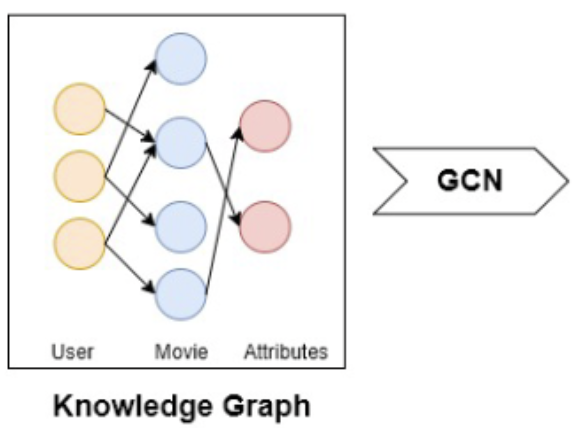

*   Movie-User-Genre
  * user-movie graph, movie-genre graph
* Edges should be weighted based on the user ratings 
  * ("bad", if the rating is lesser than 2, "avg", if the rating is between 2 and 3.5, "good" if the rating is above 3.5)
  * Should movie_id and genre node embeddings be GloVe representation?
  * Should user_id be one hot encode?
* Train GCN on this
  * How to get embedding from GCN: https://github.com/pyg-team/pytorch_geometric/issues/1559


In [ ]:
import os
import numpy as np
import pandas as pd
import networkx as nx
import itertools
import nltk
from nltk.corpus import stopwords
import re
import string
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

In [ ]:
# download ML1M dataset
!wget https://files.grouplens.org/datasets/movielens/ml-1m.zip
!unzip ml-1m.zip

--2023-04-23 03:34:04--  https://files.grouplens.org/datasets/movielens/ml-1m.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5917549 (5.6M) [application/zip]
Saving to: ‘ml-1m.zip’

ml-1m.zip           100%[===================>]   5.64M  31.7MB/s    in 0.2s    

2023-04-23 03:34:04 (31.7 MB/s) - ‘ml-1m.zip’ saved [5917549/5917549]

Archive:  ml-1m.zip
   creating: ml-1m/
  inflating: ml-1m/movies.dat        
  inflating: ml-1m/ratings.dat       
  inflating: ml-1m/README            
  inflating: ml-1m/users.dat         


In [ ]:
with open('ml-1m/movies.dat','r', encoding="ISO-8859-1") as f:
    data = f.read().splitlines()

data = list(map(lambda x: x.split('::'), data))
movies_df = pd.DataFrame(data, columns = ['movieID','title','genres'])
movies_df['movieID'] = movies_df['movieID'].astype('int')
movieID2name = dict(zip(movies_df['movieID'].values, movies_df['title'].values))

# 787: 'Gate of Heavenly Peace, The (1995)',
# 788: 'Nutty Professor, The (1996)',

# 	movieID	title	            genres
# 0	1	      Toy Story (1995)	Animation|Children's|Comedy

In [ ]:
with open('ml-1m/users.dat','r', encoding="ISO-8859-1") as f:
    data = f.read().splitlines()

data = list(map(lambda x: x.split('::'), data))
users_df = pd.DataFrame(data, columns = ['userID','gender','age','occupation','zipcode'])
users_df['userID'] = users_df['userID'].astype('int')

# 	userID	gender	age	occupation	zipcode
# 0	1	      F	      1	   10	        48067

In [ ]:
with open('ml-1m/ratings.dat','r', encoding="ISO-8859-1") as f:
    data = f.read().splitlines()

data = list(map(lambda x: x.split('::'), data))
ratings_df = pd.DataFrame(data, columns = ['userID','movieID','rating','timestamp'])
ratings_df[['userID','movieID','rating']] = ratings_df[['userID','movieID','rating']].astype('int')

# 	userID	movieID	rating	timestamp
# 0	1	      1193	  5	      978300760

In [ ]:
movies_df.shape, users_df.shape, ratings_df.shape

((3883, 3), (6040, 5), (1000209, 4))

Since userIDs and movieIDs have overlapping integers, we will change userIDs to their negative values to distinguish from movieIDs.

This is where I can implement Glove(?) https://www.projectpro.io/recipes/use-glove-embedings | https://www.kaggle.com/code/praxitelisk/moviereview-3-ml-and-pre-trained-embeddings | https://odsc.medium.com/performing-imdb-sentiment-analysis-with-glove-embeddings-64035c1c9e8c | https://predictivehacks.com/glove-word-embeddings-on-plot-of-the-movies/

In [ ]:
users_list = (users_df['userID'].unique() * -1).tolist()
movies_list = movies_df['movieID'].unique().tolist()
genres_list = list(map(lambda x: x.split('|'), movies_df.genres.values.tolist()))
genres_list = list(set(itertools.chain(*genres_list)))

print('Number of Users:', len(users_list)) 
print('Number of Movies:', len(movies_list))
print('Number of Genres:', len(genres_list))

Number of Users: 6040
Number of Movies: 3883
Number of Genres: 18


In [ ]:
y = ratings_df['rating'] / 5
print(y)
# print(ratings_df['rating'])
print(len(ratings_df['rating']))

0          1.0
1          0.6
2          0.6
3          0.8
4          1.0
          ... 
1000204    0.2
1000205    1.0
1000206    1.0
1000207    0.8
1000208    0.8
Name: rating, Length: 1000209, dtype: float64
1000209


## Movies GloVe Vector

Since we have different number of words for each movie title, we will average it.

In [ ]:
!wget http://nlp.stanford.edu/data/glove.6B.zip  
!unzip glove.6B.zip 

--2023-04-23 03:34:10--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2023-04-23 03:34:10--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2023-04-23 03:34:11--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [ ]:
embeddings_dict = {}
with open("glove.6B.50d.txt", 'r', encoding="utf8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], "float32")
        embeddings_dict[word] = vector

In [ ]:
# Check embedding of the word 'movie'
embeddings_dict['movie']

array([ 0.30824 ,  0.17223 , -0.23339 ,  0.023105,  0.28522 ,  0.23076 ,
       -0.41048 , -1.0035  , -0.2072  ,  1.4327  , -0.80684 ,  0.68954 ,
       -0.43648 ,  1.1069  ,  1.6107  , -0.31966 ,  0.47744 ,  0.79395 ,
       -0.84374 ,  0.064509,  0.90251 ,  0.78609 ,  0.29699 ,  0.76057 ,
        0.433   , -1.5032  , -1.6423  ,  0.30256 ,  0.30771 , -0.87057 ,
        2.4782  , -0.025852,  0.5013  , -0.38593 , -0.15633 ,  0.45522 ,
        0.04901 , -0.42599 , -0.86402 , -1.3076  , -0.29576 ,  1.209   ,
       -0.3127  , -0.72462 , -0.80801 ,  0.082667,  0.26738 , -0.98177 ,
       -0.32147 ,  0.99823 ], dtype=float32)

In [ ]:
movie_name = list(movieID2name.values()) # length = 3883
movie_name[:5]

['Toy Story (1995)',
 'Jumanji (1995)',
 'Grumpier Old Men (1995)',
 'Waiting to Exhale (1995)',
 'Father of the Bride Part II (1995)']

In [ ]:
# process text
nltk.download('stopwords')

def process_text(text):
    """Process text function.
    Input:
        text: a string containing a text
    Output:
        text_clean: a list of words containing the processed text
 
    """
    # turn it to lower case
    text = text.lower()
    # replace apostrophe with space
    text = re.sub('\'', ' ', text)
    # remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))  
    # remove digits
    text = re.sub('\d', '', text)
     
    stopwords_english = stopwords.words('english')
 
    text_clean = ""
    text = text.split(' ')
    for word in text:
        if (word not in stopwords_english):  # remove punctuation
            # text_clean.append(word)
            text_clean = text_clean +" "+word
     
    # remove double spaces
    text_clean = re.sub(' +', ' ', text_clean)
    # strip text
    text_clean = text_clean.strip()
 
    return text_clean

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
clean_movie_name =[]

for i in range(len(movie_name)):
  clean_movie_name.append(process_text(movie_name[i]))

In [ ]:
clean_movie_name[:5]

['toy story',
 'jumanji',
 'grumpier old men',
 'waiting exhale',
 'father bride part ii']

In [ ]:
movie_name_rep = []
for name in clean_movie_name:  
    temp_name = []
    
    for word in name.split(" "):    
        if word in embeddings_dict:
            temp = embeddings_dict[str(word)]
        else:
            temp = np.zeros(50)

        temp_name.append(temp)
    
    temp_name = np.mean(temp_name, axis=0)
    movie_name_rep.append(temp_name)

In [ ]:
movie_name_rep[:1]

[array([ 0.158795  , -0.06782001, -0.065135  ,  0.13362001,  0.77895   ,
         0.53516   , -0.87336   , -1.0763199 ,  0.08622502,  0.0697835 ,
        -0.530055  ,  0.39126   , -0.3984865 ,  0.43801   ,  0.88746   ,
        -0.138805  , -0.49887997,  0.58833   , -0.38617   , -0.29517502,
         0.81153   ,  0.27995002, -0.42463216,  0.391485  ,  0.5207205 ,
        -1.1935    , -1.70115   ,  0.1558425 ,  0.47346002, -0.82007   ,
         1.90215   , -0.43124503,  0.40531003,  0.16766001,  0.01508501,
         0.53734   , -0.06223001, -0.32498997, -0.043578  , -0.50997   ,
         0.028965  ,  0.170165  , -0.1693995 , -0.28026998,  0.58851004,
         0.57069004,  0.465075  , -0.33985   ,  0.16919   ,  0.27117002],
       dtype=float32)]

## Genres GloVe Vector

In [ ]:
# In the order of genres_list, create glove emb for genre
genre_rep = []
gen_list = ['war',
'documentary',
'animation',
'musical',
'crime',
'adventure',
'western',
'children',
'fantasy',
'drama',
'action',
'mystery',
'romance',
'noir',
'comedy',
'horror',
'sci-fi',
'thriller']
for gen in gen_list:  

    if gen in embeddings_dict:
        temp = embeddings_dict[gen]
    else:
        temp = np.zeros(50)
    
    genre_rep.append(temp)

In [ ]:
print(genres_list)
print(genre_rep[:1])

['Documentary', 'Comedy', 'Romance', 'War', 'Mystery', 'Western', 'Crime', 'Drama', 'Adventure', "Children's", 'Horror', 'Fantasy', 'Thriller', 'Film-Noir', 'Animation', 'Action', 'Sci-Fi', 'Musical']
[array([ 0.36544 , -0.15746 , -0.23966 , -1.0307  , -0.070691,  0.21397 ,
       -0.041914,  0.28451 , -0.60803 , -1.1451  , -0.32878 , -0.20474 ,
       -0.81884 , -0.50994 ,  0.64189 , -0.54164 ,  0.019143,  0.18778 ,
       -0.66691 ,  0.93691 ,  0.03469 , -0.04457 , -0.014529, -0.76871 ,
       -0.20773 , -2.551   , -0.96284 , -0.61126 ,  1.2183  ,  1.1249  ,
        3.0499  , -0.38817 , -1.0091  , -0.47156 , -0.56735 ,  0.53067 ,
       -0.61745 , -0.61581 , -1.1875  , -0.21176 , -0.50487 , -0.24842 ,
        0.53851 , -0.98083 ,  0.089771,  0.24673 , -0.33966 ,  0.011441,
       -1.4997  , -0.39907 ], dtype=float32)]


# User-Movie, Movie-Genre Bipartite Graph

In [ ]:
# adding nodes
def add_nodes(G, users_list, movies_list, genres_list):
    for i in range(len(users_list)):
      G.add_node(users_list[i], emb=user_rep[i])

    for i in range(len(movies_list)):
      G.add_node(movies_list[i], emb=movie_name_rep[i])
    
    for i in range(len(genres_list)):
      G.add_node(genres_list[i], emb=genre_rep[i])

In [ ]:
def add_user_movie_edges(G, ratings_df):
    # building relations between users and movies where users rated movies >=3
    bad_idx = ratings_df[ratings_df['rating']<2].index
    avg_idx = ratings_df[(ratings_df['rating']>=2) & (ratings_df['rating']<3.5)].index
    good_idx = ratings_df[ratings_df['rating']>=3.5].index

    print("bad ", len(bad_idx), "avg ", len(avg_idx), "good ", len(good_idx))

    # adding user-movie edges
    bad_edges = list(tuple(zip(-ratings_df.loc[bad_idx,'userID'].values, ratings_df.loc[bad_idx,'movieID'].values, [{'weight':-3}] * len(bad_idx))))
    avg_edges = list(tuple(zip(-ratings_df.loc[avg_idx,'userID'].values, ratings_df.loc[avg_idx,'movieID'].values, [{'weight':0}] * len(avg_idx))))
    good_edges = list(tuple(zip(-ratings_df.loc[good_idx,'userID'].values, ratings_df.loc[good_idx,'movieID'].values, [{'weight':3}] * len(good_idx))))
    
    
    G.add_edges_from(bad_edges)
    G.add_edges_from(avg_edges)
    G.add_edges_from(good_edges)

In [ ]:
def add_movie_genre_edges(G, movies_df):
    # adding movie genre edges
    genres_list = list(map(lambda x:x.split('|'), movies_df['genres'].values))
    movie_ids_list = list(map(lambda x, y: [x] * len(genres_list[y]), movies_df['movieID'].values, movies_df.index))

    flattened_movieids = list(itertools.chain(*movie_ids_list))
    flattened_genres = list(itertools.chain(*genres_list)) 

    # ensuring 1-1 map between movies and genres
    assert len(flattened_movieids) == len(flattened_genres)

    edges = list(tuple(zip(flattened_movieids, flattened_genres, [{'weight':1}] * len(flattened_movieids))))
    G.add_edges_from(edges)

In [ ]:
G = nx.DiGraph()
add_nodes(G, users_list, movies_list, genres_list)
add_user_movie_edges(G, ratings_df)
add_movie_genre_edges(G, movies_df)

assert len(G.nodes()) == len(users_list) + len(movies_list) + len(genres_list)

print('Final number of nodes: ', len(G.nodes()))
print('Final number of edges: ', len(G.edges()))

bad  56174 avg  368754 good  575281
Final number of nodes:  9941
Final number of edges:  1006617


In [ ]:
ratings_df['rating_norm'] = ratings_df['rating']/5
ratings_df

,userID,movieID,rating,timestamp,rating_norm
0,1,1193,5,978300760,1.0
1,1,661,3,978302109,0.6
2,1,914,3,978301968,0.6
3,1,3408,4,978300275,0.8
4,1,2355,5,978824291,1.0
...,...,...,...,...,...
1000204,6040,1091,1,956716541,0.2
1000205,6040,1094,5,956704887,1.0
1000206,6040,562,5,956704746,1.0
1000207,6040,1096,4,956715648,0.8


In [ ]:
bad_idx = ratings_df[ratings_df['rating']<2].index
avg_idx = ratings_df[(ratings_df['rating']>=2) & (ratings_df['rating']<3.5)].index
good_idx = ratings_df[ratings_df['rating']>=3.5].index

y_all = []

bad_rating = ratings_df.loc[bad_idx,'rating_norm'].values
avg_rating = ratings_df.loc[avg_idx,'rating_norm'].values
good_rating = ratings_df.loc[good_idx,'rating_norm'].values

for i in range(len(bad_rating)):
  y_all.append(bad_rating[i])

for i in range(len(avg_rating)):
  y_all.append(avg_rating[i])

for i in range(len(good_rating)):
  y_all.append(good_rating[i])

# for movie_genre edge, make it 0.
for i in range(6408):
  y_all.append(0)


print(len(y_all))

1006617


In [ ]:
# Check if weight is properly applied
G[-1][1]["weight"]

3

In [ ]:
# Check if it is bipartite graph
print(list(G.neighbors(-1))[:5])
print(list(G.neighbors(661)))
print(list(G.neighbors(1)))

[661, 914, 1197, 2687, 2321]
['Animation', "Children's", 'Musical']
['Animation', "Children's", 'Comedy']


In [ ]:
movies_list[:5]

[1, 2, 3, 4, 5]

In [ ]:
# Check movie node attribute (glove embedding)
glove = nx.get_node_attributes(G, "emb")
print(glove[-1]) # user
print(glove[1]) # movie
print(glove["Sci-Fi"]) # genre

[-0.32313   0.89266   0.54943   0.59294   0.56707   0.37888  -0.036071
 -0.18445  -0.6102   -0.27874   0.1987   -0.13458  -0.12     -0.80437
  0.69032  -0.56864  -0.3787    0.022928 -1.6365    0.43987   0.2869
 -0.99327   1.2016    0.40906  -1.0473   -0.80572   0.78073  -0.298
  0.49566  -0.18523   3.6489    0.30559  -0.59888   0.84786   0.30806
 -0.46975   0.51175   0.44654   0.86962  -0.83334   0.95202  -0.68141
  0.52714  -0.9841   -0.68455   1.1837    0.16568  -0.34587   0.49963
  0.47765 ]
[ 0.158795   -0.06782001 -0.065135    0.13362001  0.77895     0.53516
 -0.87336    -1.0763199   0.08622502  0.0697835  -0.530055    0.39126
 -0.3984865   0.43801     0.88746    -0.138805   -0.49887997  0.58833
 -0.38617    -0.29517502  0.81153     0.27995002 -0.42463216  0.391485
  0.5207205  -1.1935     -1.70115     0.1558425   0.47346002 -0.82007
  1.90215    -0.43124503  0.40531003  0.16766001  0.01508501  0.53734
 -0.06223001 -0.32498997 -0.043578   -0.50997     0.028965    0.170165
 -0.1693

### Save Graph

In [ ]:
import pickle

# save graph object to file
pickle.dump(G, open('ml1m.pickle', 'wb'))

# load graph object from file
G = pickle.load(open('ml1m.pickle', 'rb'))

print('Number of nodes: ', len(G.nodes()))
print('Number of edges: ', len(G.edges()))

Number of nodes:  9941
Number of edges:  1006617


### Plotting Knowledge Graph

To get a glimpse of relations between entities, select few user, movie, genre

In [ ]:
import matplotlib

def plot_graph(graph_path, n_users, n_movies, n_genres, seed):
    
    # loading networkx graph
    nodes = G.nodes()

    user_nodes = []
    movie_nodes = []
    genre_nodes = []
    for node in nodes:
        if isinstance(node, int):
            if node<0:
                user_nodes.append(node)
            else:
                movie_nodes.append(node)
        else:
            genre_nodes.append(node)

    # seeding for reproducibility
    np.random.seed(seed)
    chosen_users = np.random.choice(user_nodes, n_users, replace=False).astype('int').tolist()
    chosen_movies = np.random.choice(movie_nodes, n_movies, replace=False).astype('int').tolist()
    chosen_genres = np.random.choice(genre_nodes, n_genres, replace=False).tolist()
    chosen_nodes = chosen_users + chosen_movies + chosen_genres

    # excluding non-relevant nodes
    for node in list(nodes):
        if node not in chosen_nodes:
            G.remove_node(node)

    print('Number of nodes in plotted Graph: ', len(G.nodes()))
    print('Number of edges in plotted Graph: ', len(G.edges()))

    # defining labels 
    # defining node colors
    labels = {}
    node_colors = []
    for node in G.nodes():
        if isinstance(node, int):
            if node > 0:
                labels[node] = movieID2name[node]
                node_colors.append('lightblue')
            else:
                labels[node] = 'userID: ' + str(-node)     
                node_colors.append('lavender')
        else:
            labels[node] = node       
            node_colors.append('pink')

    return nx.draw(G, with_labels=True, arrows=False, node_color=node_colors, alpha=0.9, labels=labels) 

Number of nodes in plotted Graph:  60
Number of edges in plotted Graph:  79


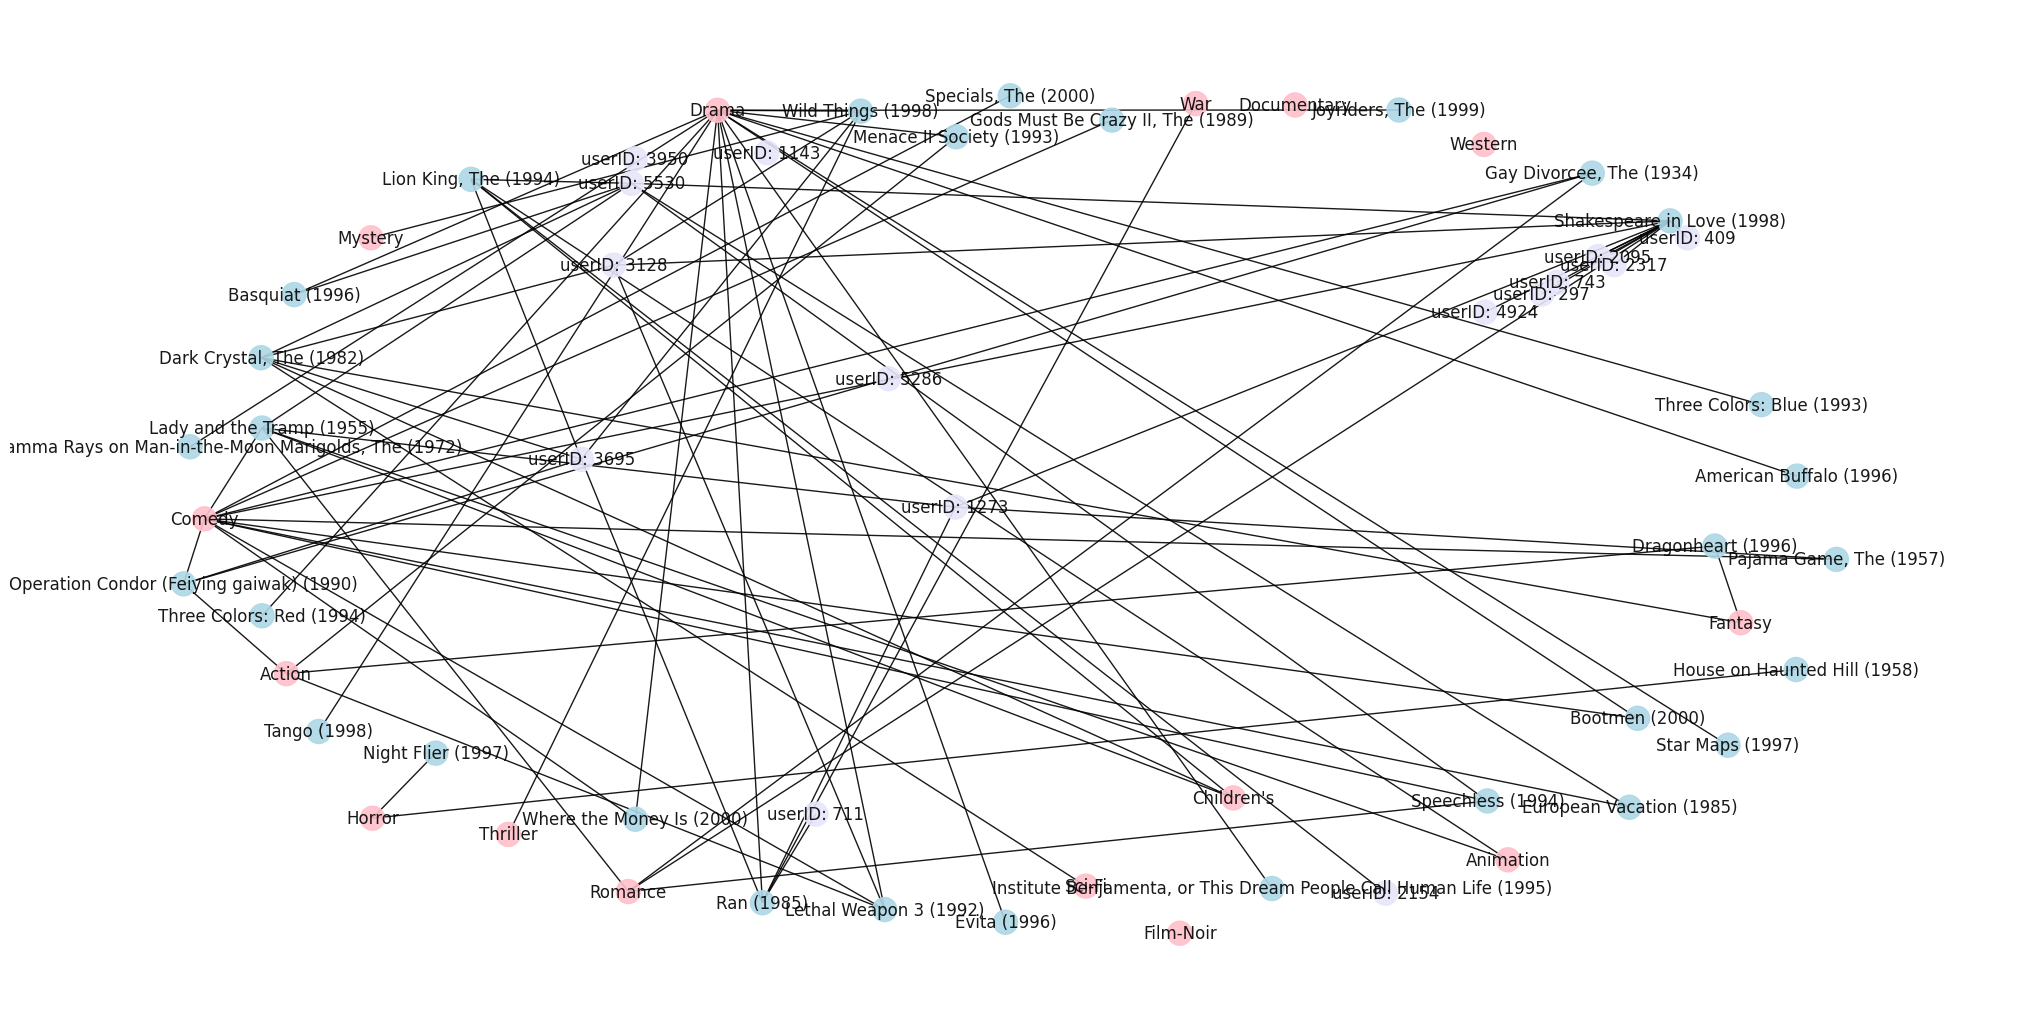

In [ ]:
plt.figure(figsize=(20,10))
n_users = 15
n_movies = 30   
n_genres = 15
seed = 42

# plotting the graph
graph_path = 'ml1m.gpickle'
plot_graph(graph_path, n_users, n_movies, n_genres, seed)
plt.show()